## Preprocessing

In [56]:
import torch
from torchtext.legacy import data
import nltk
stp = nltk.corpus.stopwords.words('english') 

def generate_bigrams(x):
    # Remove stopwords
    x = [t for t in x if t not in stp]
    #Create bigrams
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    
    return x


## Create multiple models

### MODEL SIMPLE BERT GRU

In [85]:
from transformers import BertModel, BertTokenizer

class BERTGRU(nn.Module):
    def __init__(self,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        embedding_dim = self.bert.config.to_dict()['hidden_size']
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, features):
        #text, attn_masks = features
        with torch.no_grad():
            embedded = self.bert(features)[0]
        _, hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.out(hidden)
        
        return output

### MODEL FASTEXT

In [2]:
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn


class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        super().__init__() 
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, features):
        text, text_len = features
        embedded = self.embedding(text)
        embedded = embedded.permute(1, 0, 2)
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
                
        return self.fc(pooled)

### MODEL BILSTM

In [3]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, mix_layer, extra_layer,pad_idx):   
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear((hidden_dim * 2), output_dim)
        #self.fc = nn.Linear((hidden_dim * 2)+3, mix_layer)
        #self.fc2 = nn.Linear(mix_layer, extra_layer)
        #self.fc3 = nn.Linear(extra_layer, output_dim)
        
    def forward(self, features):
        text, text_lengths = features
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False) 
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        final = self.fc(hidden)#.squeeze(-1))
        #print(hidden.squeeze(1).shape, extra.unsqueeze(1).shape)
        #extras = self.fc(torch.cat((hidden.squeeze(1),extra),dim=1))
        #line = F.relu(self.fc2(extras))
        #final = self.fc3(line)
            
        return final

#### Aux function train, evaluate, develop

In [9]:
def train(model, iterator, optimizer, criterion): 
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.t).squeeze(1)
        loss = criterion(predictions, batch.l.float())
        #acc = binary_accuracy(predictions, batch.l)
        acc = f1_scoring(predictions, batch.l)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0 
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.t).squeeze(1)
            loss = criterion(predictions, batch.l.float())
            #acc = binary_accuracy(predictions, batch.l)
            acc = f1_scoring(predictions, batch.l)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def f1_scoring(preds, y):
    from sklearn.metrics import f1_score
    import numpy as np
    rounded_preds = torch.round(torch.sigmoid(preds))
    score = f1_score(y.tolist(), rounded_preds.tolist())
    return torch.from_numpy(np.array(score))
    
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def develop(model, train_iterator, dev_iterator, optimizer, criterion, N_EPOCHS, title):

    best_valid_loss = 0
    report = title + '\n'

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, dev_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_acc > best_valid_loss:
            best_valid_loss = valid_acc
            #torch.save(model.state_dict(), 'tut3-model.pt')

        report += f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s \n'
        report += f'\tTrain Loss: {train_loss:.3f} | Train F1: {train_acc*100:.2f}% \n'
        report += f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {valid_acc*100:.2f}% \n'
    report += f'Best F1 Score: {best_valid_loss} \n'
        
    return report

### Run functions

In [83]:
def run_experiements(model, args, epoch, pre_pros, bert = False):
    trainings = ["trainSimpleNT.json", "trainDateNT.json", "trainDepthNT.json", "trainLikeNT.json"]
    developings = ["devSimpleNT.json", "devDateNT.json", "devDepthNT.json", "devLikeNT.json"]
    reports = []

    MAX_VOCAB_SIZE = 25_000
    BATCH_SIZE = 16
    max_input_length = 256
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for t,d in zip(trainings, developings):
        
        if bert:
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            init_token_idx = tokenizer.cls_token_id
            eos_token_idx = tokenizer.sep_token_id
            pad_token_idx = tokenizer.pad_token_id
            unk_token_idx = tokenizer.unk_token_id
            
            def tokenize_and_cut(sentence):
                tokens = tokenizer.tokenize(sentence)
                tokens = [t for t in tokens if t not in stp]
                tokens = tokens[:max_input_length-2]
                return tokens
            
            TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)
        else:
            TEXT = data.Field(tokenize = 'spacy',
                          tokenizer_language = 'en_core_web_sm',
                          preprocessing = pre_pros, sequential=True, include_lengths=True)

        LABEL = data.LabelField(dtype = torch.float)

        train_data, dev_data = data.TabularDataset.splits(
                                path ='./',
                                train = t,
                                validation = d,
                                format = 'json',
                                fields = {'text': ('t', TEXT), 'label': ('l', LABEL)})
        
        if bert:
            print('bert baby!!')
        else:
            TEXT.build_vocab(train_data, 
                         max_size = MAX_VOCAB_SIZE, 
                         vectors = "glove.6B.100d", 
                         unk_init = torch.Tensor.normal_)

        LABEL.build_vocab(train_data)

        train_iterator, dev_iterator = data.BucketIterator.splits(
            (train_data, dev_data), 
            batch_size = BATCH_SIZE,
            sort_key = lambda x: len(x.t),
            device = device)
        if bert:
            modelF = model(**args, output_dim =1)
        else:
            modelF = model(vocab_size = len(TEXT.vocab), **args, output_dim =1 ,pad_idx = TEXT.vocab.stoi[TEXT.pad_token])

        optimizer = optim.Adam(modelF.parameters())
        criterion = nn.BCEWithLogitsLoss()

        modelF = modelF.to(device)
        criterion = criterion.to(device)

        rep = develop(modelF, train_iterator, dev_iterator, optimizer, criterion, N_EPOCHS = epoch, title = d)
        reports.append(rep)
        print(rep)
        torch.cuda.empty_cache()
    return reports

# Experiments

In [53]:
def plot_train(resultados):
    """
    Parse Results to plot trainig process
    """
    for i in range(4):
        epoch,t_loss, v_loss, t_f1, v_f1 = [],[],[],[],[]
        for d in resultados[i].split('\n'):
            if 'json' in d:
                title = d[:-5]
            elif 'Epoch' in d:
                epoch.append(str(d[7:9]))
            elif 'Train' in d:
                t_loss.append(float(d[13:18]))
                t_f1.append(float(d[31:35])/100)
            elif 'Val' in d:
                v_loss.append(float(d[13:18]))
                v_f1.append(float(d[31:35])/100)

        pd.DataFrame({'epoch':epoch, 'Train_loss': t_loss, 'Valid_loss':v_loss, 'Train_F1': t_f1, 'Val_F1':v_f1 }).plot(kind='line', title= title, xlabel='Epochs', ylabel='score')
        


### Fast text

In [59]:
param = {"embedding_dim": 100 }

fast_text = run_experiements(FastText, param,30, generate_bigrams)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


devSimpleNT.json
Epoch: 01 | Epoch Time: 0m 4s 
	Train Loss: 0.657 | Train F1: 5.66% 
	 Val. Loss: 0.655 |  Val. F1: 0.00% 
Epoch: 02 | Epoch Time: 0m 4s 
	Train Loss: 0.640 | Train F1: 0.00% 
	 Val. Loss: 0.616 |  Val. F1: 0.00% 
Epoch: 03 | Epoch Time: 0m 4s 
	Train Loss: 0.622 | Train F1: 0.09% 
	 Val. Loss: 0.602 |  Val. F1: 5.09% 
Epoch: 04 | Epoch Time: 0m 4s 
	Train Loss: 0.601 | Train F1: 2.24% 
	 Val. Loss: 0.543 |  Val. F1: 19.08% 
Epoch: 05 | Epoch Time: 0m 4s 
	Train Loss: 0.568 | Train F1: 12.44% 
	 Val. Loss: 0.461 |  Val. F1: 42.04% 
Epoch: 06 | Epoch Time: 0m 4s 
	Train Loss: 0.532 | Train F1: 27.04% 
	 Val. Loss: 0.432 |  Val. F1: 52.88% 
Epoch: 07 | Epoch Time: 0m 4s 
	Train Loss: 0.491 | Train F1: 43.94% 
	 Val. Loss: 0.437 |  Val. F1: 58.61% 
Epoch: 08 | Epoch Time: 0m 4s 
	Train Loss: 0.455 | Train F1: 53.29% 
	 Val. Loss: 0.429 |  Val. F1: 64.92% 
Epoch: 09 | Epoch Time: 0m 4s 
	Train Loss: 0.422 | Train F1: 61.14% 
	 Val. Loss: 0.438 |  Val. F1: 67.84% 
Epoch: 10

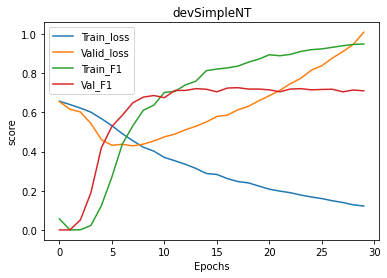

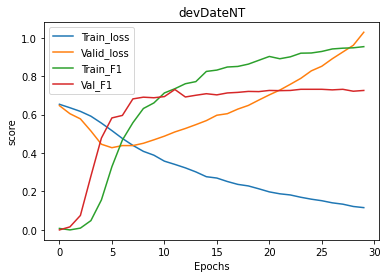

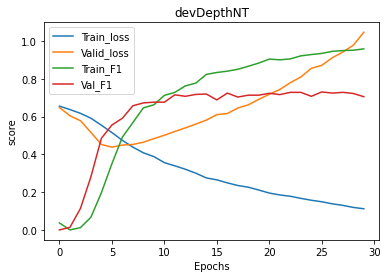

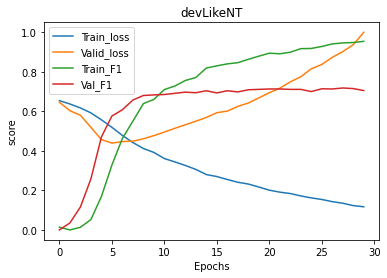

In [60]:
plot_train(fast_text)

### BILSTM

In [14]:
param2 =  {"embedding_dim":100, "hidden_dim":256, "n_layers": 2, "bidirectional": True, "dropout": 0.5, "mix_layer": 256, "extra_layer": 128}

BILSTM = run_experiements(RNN, param2, 15, None)


devSimpleNT.json
Epoch: 01 | Epoch Time: 1m 45s 
	Train Loss: 0.581 | Train F1: 38.65% 
	 Val. Loss: 0.479 |  Val. F1: 54.02% 
Epoch: 02 | Epoch Time: 1m 43s 
	Train Loss: 0.498 | Train F1: 59.72% 
	 Val. Loss: 0.434 |  Val. F1: 65.03% 
Epoch: 03 | Epoch Time: 1m 45s 
	Train Loss: 0.438 | Train F1: 66.45% 
	 Val. Loss: 0.402 |  Val. F1: 66.37% 
Epoch: 04 | Epoch Time: 1m 47s 
	Train Loss: 0.390 | Train F1: 71.35% 
	 Val. Loss: 0.397 |  Val. F1: 67.18% 
Epoch: 05 | Epoch Time: 1m 44s 
	Train Loss: 0.352 | Train F1: 75.06% 
	 Val. Loss: 0.378 |  Val. F1: 70.33% 
Epoch: 06 | Epoch Time: 10m 12s 
	Train Loss: 0.303 | Train F1: 78.63% 
	 Val. Loss: 0.373 |  Val. F1: 71.89% 
Epoch: 07 | Epoch Time: 1m 50s 
	Train Loss: 0.284 | Train F1: 80.30% 
	 Val. Loss: 0.507 |  Val. F1: 66.14% 
Epoch: 08 | Epoch Time: 1m 44s 
	Train Loss: 0.228 | Train F1: 84.51% 
	 Val. Loss: 0.467 |  Val. F1: 67.60% 
Epoch: 09 | Epoch Time: 1m 46s 
	Train Loss: 0.207 | Train F1: 86.15% 
	 Val. Loss: 0.454 |  Val. F1: 

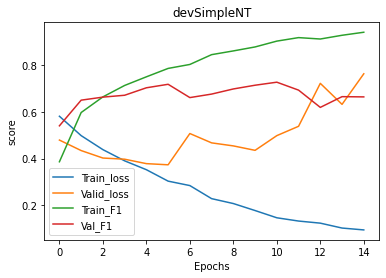

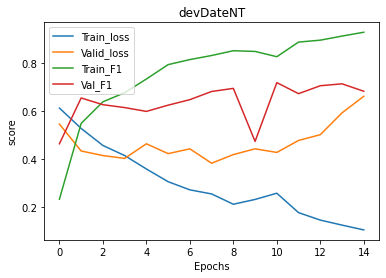

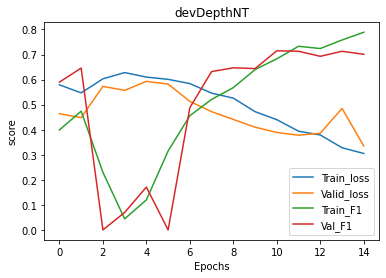

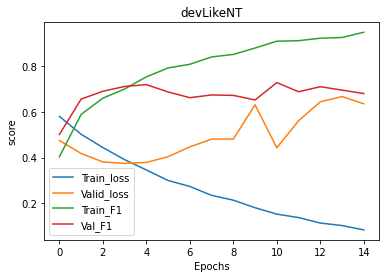

In [54]:
plot_train(BILSTM)

### BILSTM with preproccessing

In [57]:
BILSTM_tok = run_experiements(RNN, param2, 10, generate_bigrams)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


devSimpleNT.json
Epoch: 01 | Epoch Time: 2m 16s 
	Train Loss: 0.562 | Train F1: 45.02% 
	 Val. Loss: 0.490 |  Val. F1: 46.44% 
Epoch: 02 | Epoch Time: 2m 12s 
	Train Loss: 0.491 | Train F1: 58.76% 
	 Val. Loss: 0.466 |  Val. F1: 57.04% 
Epoch: 03 | Epoch Time: 2m 14s 
	Train Loss: 0.431 | Train F1: 66.95% 
	 Val. Loss: 0.388 |  Val. F1: 65.80% 
Epoch: 04 | Epoch Time: 2m 19s 
	Train Loss: 0.395 | Train F1: 70.31% 
	 Val. Loss: 0.370 |  Val. F1: 69.07% 
Epoch: 05 | Epoch Time: 2m 17s 
	Train Loss: 0.347 | Train F1: 75.13% 
	 Val. Loss: 0.396 |  Val. F1: 72.90% 
Epoch: 06 | Epoch Time: 2m 15s 
	Train Loss: 0.306 | Train F1: 79.61% 
	 Val. Loss: 0.338 |  Val. F1: 75.38% 
Epoch: 07 | Epoch Time: 2m 15s 
	Train Loss: 0.266 | Train F1: 81.11% 
	 Val. Loss: 0.367 |  Val. F1: 74.57% 
Epoch: 08 | Epoch Time: 2m 12s 
	Train Loss: 0.254 | Train F1: 83.99% 
	 Val. Loss: 0.398 |  Val. F1: 73.90% 
Epoch: 09 | Epoch Time: 2m 12s 
	Train Loss: 0.228 | Train F1: 84.07% 
	 Val. Loss: 0.394 |  Val. F1: 7

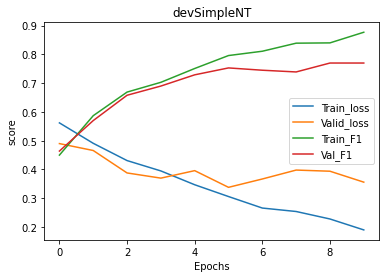

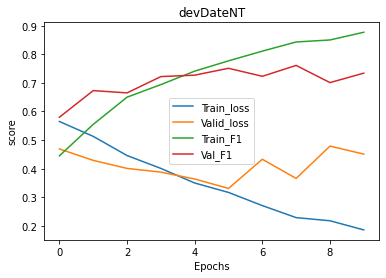

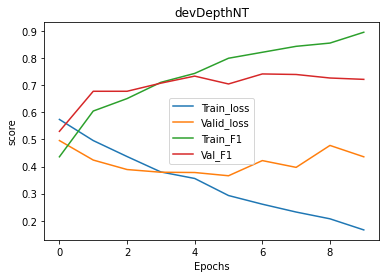

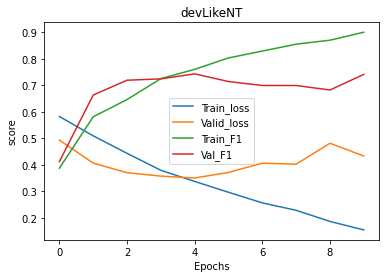

In [58]:
plot_train(BILSTM_tok)

### Simple BERT + GRU

In [77]:
param3 = {'hidden_dim':256, 'n_layers':2,'bidirectional': True,'dropout': 0.25}

BERTGRU = run_experiements(BERTGRU, param3, 5, None, True)

bert baby!!


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


devSimpleNT.json
Epoch: 01 | Epoch Time: 4m 50s 
	Train Loss: 0.466 | Train F1: 62.25% 
	 Val. Loss: 0.361 |  Val. F1: 71.49% 
Epoch: 02 | Epoch Time: 4m 50s 
	Train Loss: 0.371 | Train F1: 73.46% 
	 Val. Loss: 0.368 |  Val. F1: 78.03% 
Epoch: 03 | Epoch Time: 4m 50s 
	Train Loss: 0.302 | Train F1: 78.83% 
	 Val. Loss: 0.383 |  Val. F1: 71.11% 
Epoch: 04 | Epoch Time: 4m 54s 
	Train Loss: 0.245 | Train F1: 82.32% 
	 Val. Loss: 0.397 |  Val. F1: 74.39% 
Epoch: 05 | Epoch Time: 4m 52s 
	Train Loss: 0.195 | Train F1: 86.69% 
	 Val. Loss: 0.369 |  Val. F1: 65.42% 
Best F1 Score: 0.7803170067875951 

bert baby!!
devDateNT.json
Epoch: 01 | Epoch Time: 4m 53s 
	Train Loss: 0.465 | Train F1: 61.39% 
	 Val. Loss: 0.400 |  Val. F1: 60.30% 
Epoch: 02 | Epoch Time: 4m 56s 
	Train Loss: 0.366 | Train F1: 74.45% 
	 Val. Loss: 0.324 |  Val. F1: 76.35% 
Epoch: 03 | Epoch Time: 4m 53s 
	Train Loss: 0.297 | Train F1: 77.88% 
	 Val. Loss: 0.343 |  Val. F1: 75.66% 
Epoch: 04 | Epoch Time: 4m 57s 
	Train L

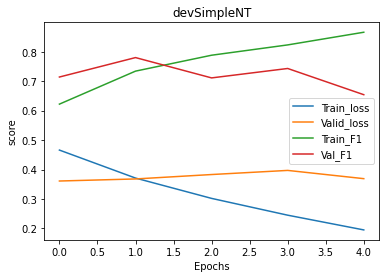

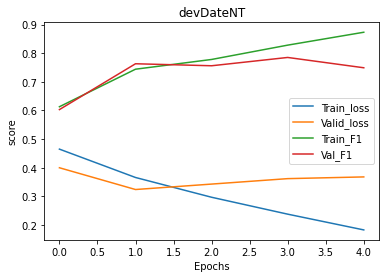

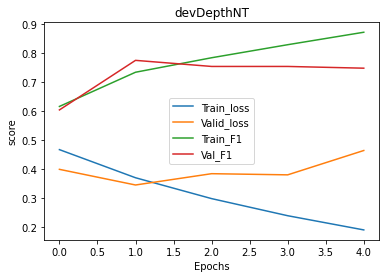

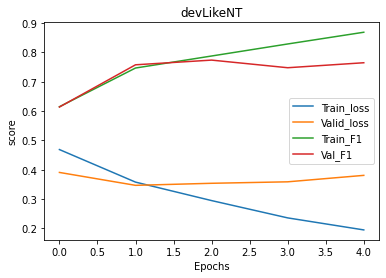

In [78]:
plot_train(BERTGRU)

### Simple BERT GRU  with prerocesing

In [86]:
#param3 = {'hidden_dim':256, 'n_layers':2,'bidirectional': True,'dropout': 0.25}
#BERT

BERTGRU_tok = run_experiements(BERTGRU, param3, 5, None, True)

bert baby!!


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


devSimpleNT.json
Epoch: 01 | Epoch Time: 4m 49s 
	Train Loss: 0.487 | Train F1: 58.37% 
	 Val. Loss: 0.398 |  Val. F1: 61.87% 
Epoch: 02 | Epoch Time: 4m 59s 
	Train Loss: 0.394 | Train F1: 71.04% 
	 Val. Loss: 0.398 |  Val. F1: 70.55% 
Epoch: 03 | Epoch Time: 4m 51s 
	Train Loss: 0.336 | Train F1: 75.20% 
	 Val. Loss: 0.337 |  Val. F1: 73.66% 
Epoch: 04 | Epoch Time: 4m 51s 
	Train Loss: 0.274 | Train F1: 80.64% 
	 Val. Loss: 0.351 |  Val. F1: 74.06% 
Epoch: 05 | Epoch Time: 4m 49s 
	Train Loss: 0.234 | Train F1: 83.30% 
	 Val. Loss: 0.345 |  Val. F1: 73.24% 
Best F1 Score: 0.7405799199916848 

bert baby!!
devDateNT.json
Epoch: 01 | Epoch Time: 4m 51s 
	Train Loss: 0.490 | Train F1: 58.48% 
	 Val. Loss: 0.411 |  Val. F1: 55.14% 
Epoch: 02 | Epoch Time: 4m 53s 
	Train Loss: 0.389 | Train F1: 71.39% 
	 Val. Loss: 0.367 |  Val. F1: 74.19% 
Epoch: 03 | Epoch Time: 4m 54s 
	Train Loss: 0.329 | Train F1: 75.87% 
	 Val. Loss: 0.346 |  Val. F1: 72.86% 
Epoch: 04 | Epoch Time: 4m 56s 
	Train L

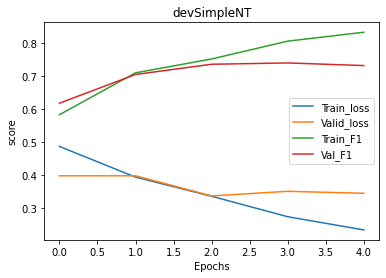

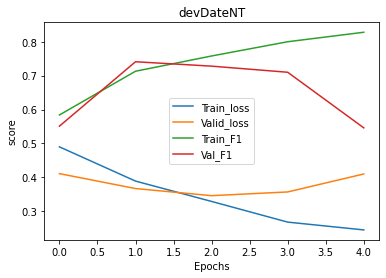

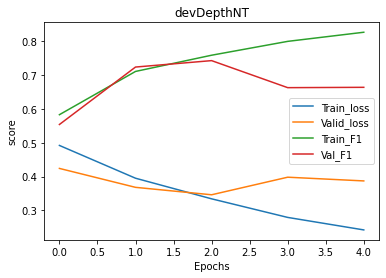

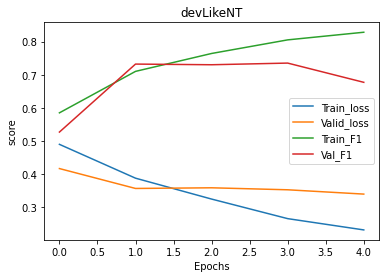

In [87]:
plot_train(BERTGRU_tok)